In [1]:
import jax.numpy as jnp
import numpy as onp
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import pandas as pd
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../models")
from linear_cr_new import LinearContrastiveRegression
# from linear_cr import LinearCR

In [2]:

sample_size_list = [20, 100, 250, 500, 750, 1000, 2000, 3000, 4000, 5000]
p = 2
d = 1


n_repititions = 5
R2_est = onp.zeros((n_repititions, len(sample_size_list)))
WWT_diff = onp.zeros((n_repititions, len(sample_size_list)))
SST_diff = onp.zeros((n_repititions, len(sample_size_list)))
Beta_diff = onp.zeros((n_repititions, len(sample_size_list)))
Tau2_diff = onp.zeros((n_repititions, len(sample_size_list)))
Sigma2_diff = onp.zeros((n_repititions, len(sample_size_list)))

for ii in range(n_repititions):
    for jj, sample_size in enumerate(sample_size_list):
        
        n, m = sample_size, sample_size
        zx = onp.random.normal(size=(n, d))
        zy = onp.random.normal(size=(m, d))
        t = onp.random.normal(size=(n, d))
        W = onp.array([[1,1]])
        S = onp.array([[-1,1]])
        beta = onp.array([[1]])
        sigma = 1e-2
        sigma2 = sigma**2 # true sigma2=1e-4
        tau = 1e-2
        tau2 = tau**2 # true tau2=1e-4

        X = zx @ S + t @ W + onp.random.normal(scale=sigma, size=(n, p))
        Y = zy @ S + onp.random.normal(scale=sigma, size=(m, p))
        R = t @ beta + onp.random.normal(scale=tau, size=(n, 1))

        model = LinearContrastiveRegression()
        model.fit(X, Y, R, d, seed = ii, verbose = False)

        preds = model.predict(X)

        _, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds)
        R2_est[ii, jj] = r2_contrastivereg


        Sigma2_diff[ii, jj] = (model.sigma_sq - sigma2).flatten().item()
        Tau2_diff[ii, jj] = (model.tau_sq - tau2).flatten().item()
        Beta_diff[ii, jj] = (abs(model.beta) - beta).flatten().item()

        WWT_diff[ii, jj] = (onp.linalg.norm(model.W.T @ model.W - W.T @ W, ord = 2)/onp.linalg.norm(W.T @ W, ord = 2))
        SST_diff[ii, jj] = (onp.linalg.norm(model.S.T @ model.S - S.T @ S, ord = 2)/onp.linalg.norm(S.T @ S, ord = 2))


In [3]:
Sigma2_df = pd.melt(pd.DataFrame(Sigma2_diff, columns=sample_size_list),
                   var_name='Sample_size', value_name = 'Estimation_error')
Sigma2_df['param'] = 'Sigma_sq'

Tau2_df = pd.melt(pd.DataFrame(Tau2_diff, columns=sample_size_list),
                   var_name='Sample_size', value_name = 'Estimation_error')
Tau2_df['param'] = 'Tau_sq'

Beta_df = pd.melt(pd.DataFrame(Beta_diff, columns=sample_size_list),
                   var_name='Sample_size', value_name = 'Estimation_error')
Beta_df['param'] = 'Beta'

W_df = pd.melt(pd.DataFrame(WWT_diff, columns=sample_size_list),
                   var_name='Sample_size', value_name = 'Estimation_error')
W_df['param'] = 'W'

S_df = pd.melt(pd.DataFrame(SST_diff, columns=sample_size_list),
                   var_name='Sample_size', value_name = 'Estimation_error')
S_df['param'] = 'S'

In [4]:
df_long1 = pd.concat([Sigma2_df, Tau2_df, Beta_df, W_df, S_df])
df_long1['param'] = df_long1['param'].astype('category')
df_long1['param'].cat.reorder_categories(['Beta', 'Tau_sq', 'Sigma_sq', 'S', 'W'], inplace=True)

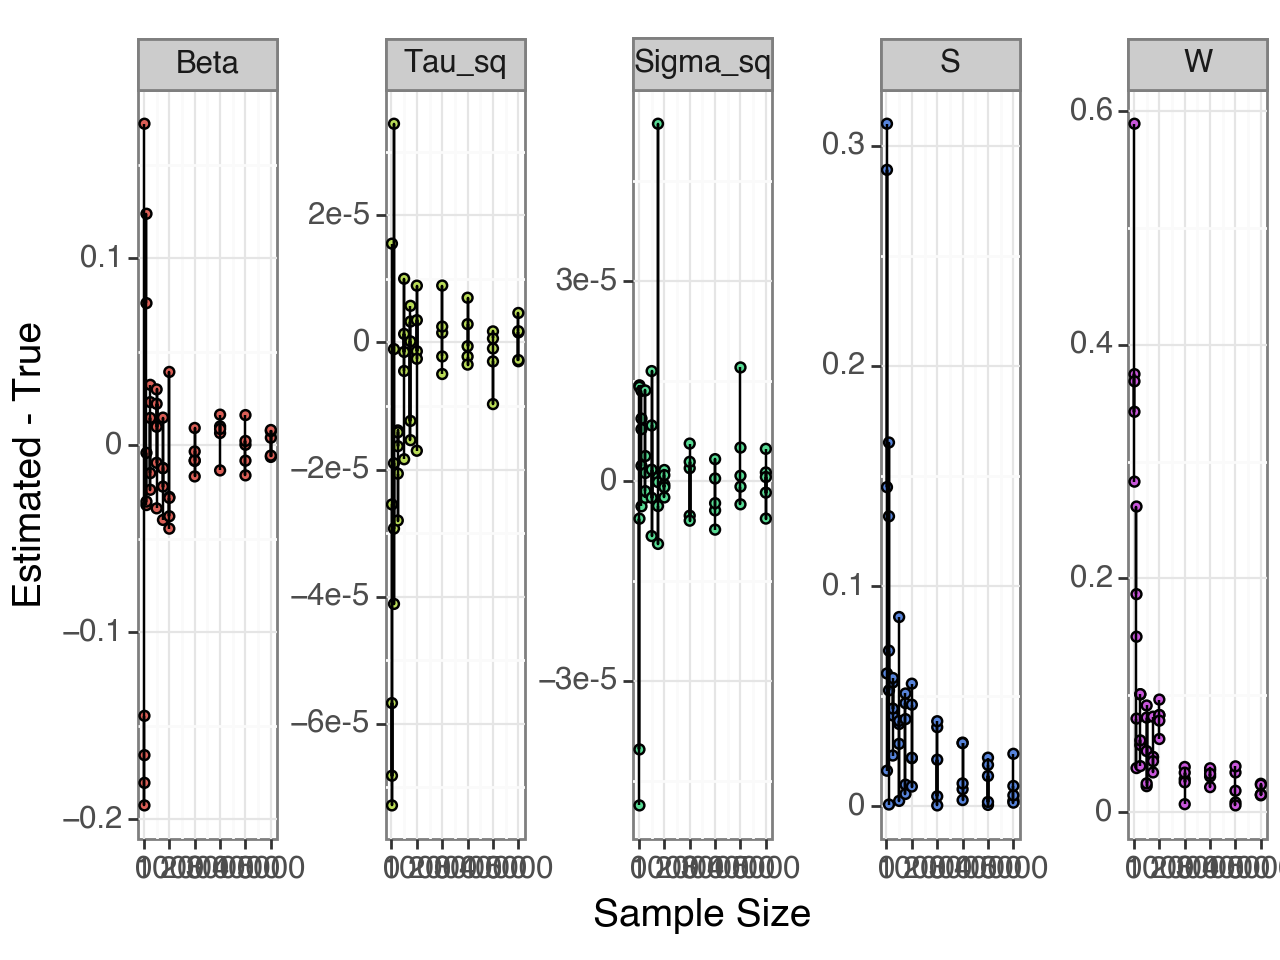

<Figure Size: (640 x 480)>

In [5]:
# plot
p = (
    ggplot(df_long1) + aes(x="Sample_size", y="Estimation_error", fill = "param", group = "Sample_size")
    # + geom_boxplot()
    # + geom_jitter(alpha = 0.6, width = 0.1)
    + geom_point()
    + geom_line()
    + facet_wrap('param',
                 ncol = 5,
                 scales = 'free'
                )
    + xlab("Sample Size")
    + ylab("Estimated - True")
    + theme_bw(base_size = 14)
    + theme(legend_position = 'none')
)
p


In [7]:
p.save(filename = './out/simulation_consistency_new.png', width = 15, height = 4, units = 'in', dpi = '300')